In [1]:
import torch
import numpy as np
from dist_ae import SetAutoencoderGNN, SetAutoencoderTx, train_w_stop
from distns import distns
from tqdm.notebook import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

distn_name = 'poisson'
pois_generate_params = distns[distn_name]['generate_params']
pois_sample_distn = distns[distn_name]['sample']

distn_name = 'normal'
normal_sample_distn = distns[distn_name]['sample']

In [2]:
def normal_generate_params(n_sets, n_features, rate_range=(1, 100)):
    mu = np.random.uniform(rate_range[0], rate_range[1], size=(n_sets, n_features))
    # var = np.random.uniform(rate_range[0], rate_range[1], size=(n_sets, n_features))
    return mu.squeeze(), mu.squeeze()

In [3]:
max_mean = 10

def mix_distributions(dist_fns, set_number, set_size, n_features):
    """generate mixed dataset from given distributions and proportions"""
    sets = []
    for generate_params, sample_distn, prop in dist_fns:
        num_samples = int(set_number * prop)
        params = generate_params(num_samples, n_features, rate_range=(0.1, max_mean))
        sets.append(sample_distn(*params, num_samples, set_size, n_features))
    return np.concatenate(sets, axis=0)

n_features = 2
set_number = 2*10**4 
set_size = 5*10**2
proportions = [0.5, 0.5]
test_sets = 5000

# prepare functions
pois_fns = (pois_generate_params, pois_sample_distn, proportions[0])
normal_fns = (normal_generate_params, normal_sample_distn, proportions[1])

dist_fns = [pois_fns, normal_fns]

# generate datasets
x_train = mix_distributions(dist_fns, set_number, set_size, n_features)
x_val = mix_distributions(dist_fns, set_number // 4, set_size, n_features)
x_test = mix_distributions(dist_fns, test_sets, set_size, n_features)

# x_train = x_train[:, :, 0:1]
# x_val = x_val[:, :, 0:1]
# x_test = x_test[:, :, 0:1]
test_labels = ['Poisson']*int(proportions[0]*test_sets) + ['Normal']*int(proportions[1]*test_sets)

# create dataloaders
train_loader = torch.utils.data.DataLoader(torch.from_numpy(x_train).float(), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.from_numpy(x_val).float(), batch_size=32, shuffle=False)

In [4]:
dist_ae = SetAutoencoderGNN(2, 16, 64, set_size)
optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

dist_ae = train_w_stop(dist_ae, optimizer, 
                    train_loader, val_loader,
                    max_epochs = 200, device='cuda',
                    verbose=True, patience=200)

with torch.no_grad():
    z, rec = dist_ae(torch.from_numpy(x_test).float().cuda())

Epoch 1 | Train Loss: 5.8446 | Val Loss: 0.2129
Epoch 2 | Train Loss: 0.1271 | Val Loss: 0.0922
Epoch 3 | Train Loss: 0.0995 | Val Loss: 0.1138
Epoch 4 | Train Loss: 0.0715 | Val Loss: 0.0645
Epoch 5 | Train Loss: 0.0811 | Val Loss: 0.0613
Epoch 6 | Train Loss: 0.0746 | Val Loss: 0.0637
Epoch 7 | Train Loss: 0.0799 | Val Loss: 0.0755
Epoch 8 | Train Loss: 0.0729 | Val Loss: 0.0640
Epoch 9 | Train Loss: 0.0740 | Val Loss: 0.0627
Epoch 10 | Train Loss: 0.0739 | Val Loss: 0.0641
Epoch 11 | Train Loss: 0.0785 | Val Loss: 0.0585
Epoch 12 | Train Loss: 0.0651 | Val Loss: 0.0658
Epoch 13 | Train Loss: 0.0736 | Val Loss: 0.0951
Epoch 14 | Train Loss: 0.0753 | Val Loss: 0.0578
Epoch 15 | Train Loss: 0.0680 | Val Loss: 0.0886
Epoch 16 | Train Loss: 0.0633 | Val Loss: 0.0628
Epoch 17 | Train Loss: 0.0798 | Val Loss: 0.0636
Epoch 18 | Train Loss: 0.0681 | Val Loss: 0.0828
Epoch 19 | Train Loss: 0.0665 | Val Loss: 0.1103
Epoch 20 | Train Loss: 0.0689 | Val Loss: 0.0669
Epoch 21 | Train Loss: 0.0693

In [5]:
from umap import UMAP

In [6]:
umap = UMAP(n_components=2)
vis = umap.fit_transform(z.cpu().numpy())

/home/gokulg/.conda/envs/metaMI/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

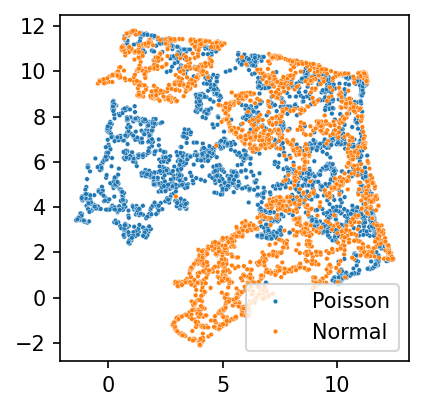

In [7]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], hue=test_labels, s=5)

<Axes: >

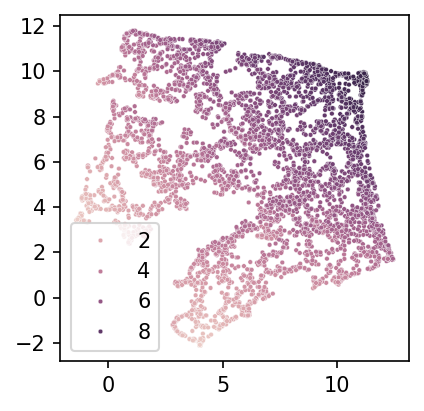

In [8]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], hue=x_test.mean(axis=(1,2)), s=5)

In [9]:
def kernel_mean_embedding(samples, kernel):
    n = samples.shape[0]
    return lambda q: kernel(np.atleast_2d(q), samples).mean(axis=1)

def rbf_kernel(x, y, sigma=1.0):
    diff = x[:, None, :] - y[None, :, :]
    return np.exp(-np.sum(diff**2, axis=2) / (2 * sigma**2))

In [10]:
kme_z = np.array([kernel_mean_embedding(x, rbf_kernel)(x) for x in x_test])

In [11]:
umap = UMAP(n_components=2)
vis = umap.fit_transform(kme_z)

/home/gokulg/.conda/envs/metaMI/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

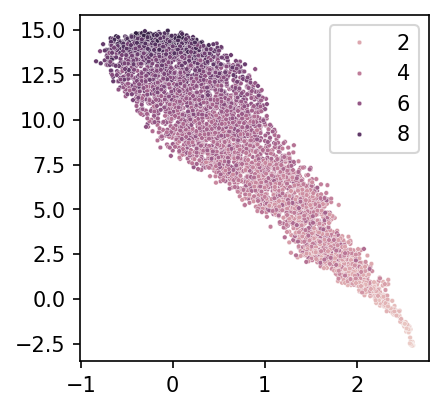

In [14]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], hue=x_test.mean(axis=(1,2)), s=5)

<Axes: >

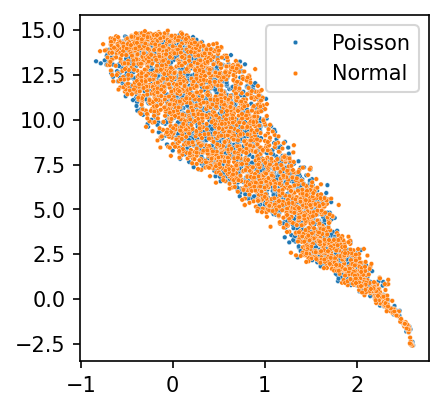

In [15]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], hue=test_labels, s=5)